In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask
import matplotlib.pyplot as plt

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("INFO")
utl.log.setLevel("DEBUG")

# data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"
data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")
os.makedirs('../img', exist_ok=True)

2024-05-24 08:45:54,623 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [2]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2024-05-24 08:45:57,715 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2024-05-24 08:45:57,716 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN


In [3]:
# Preprocessing of data
# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
# TODO: 0.05 firing rate threshold seems better
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R >= 0.0")
meta_df = meta_df.query("tau_double >= 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-24 08:46:02,095 | INFO     | notebook | <module> | removed 923 rows due to unexpected timescales


In [4]:
# we need a mapping from ephys acronyms to the names we use in the paper
structure_names = {
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

# TODO: dump the final, cleaned dataframe to disk again.

meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf,structure_name
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False,AM
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False,AM
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True,AM
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True,AM
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN,AL
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN,AL
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN,AL
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN,AL


2024-05-24 08:47:21,276 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:47:21,279 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4585 rows
2024-05-24 08:47:22,778 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:47:22,780 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4585 rows
2024-05-24 08:47:24,263 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:47:24,265 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 4585 rows


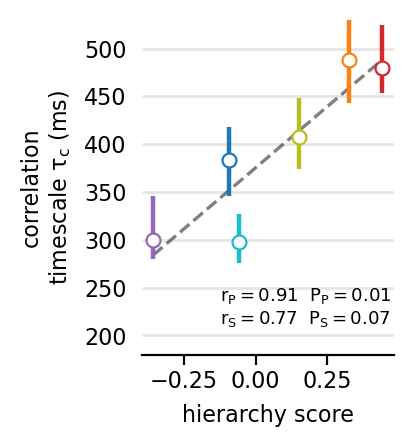

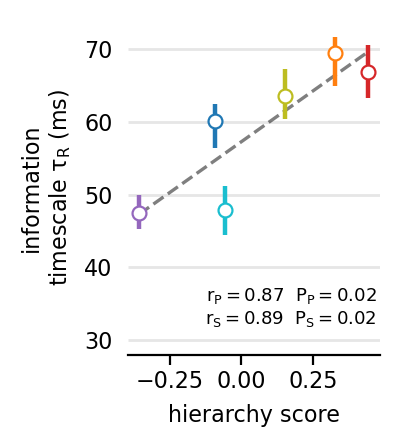

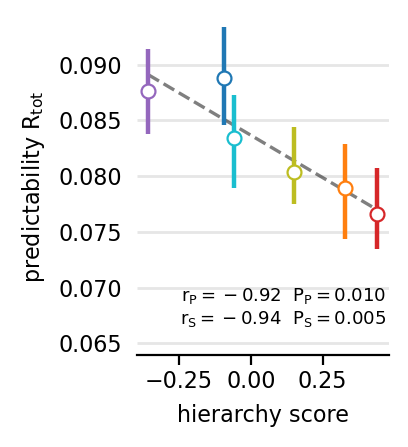

In [11]:
from bitsandbobs.plt import set_size

# my set_size applies these to the ax-element to make sure that the plotted content has
# consistent size. native mpl figsize makes the plot area inconsistent to space labels
size_kwargs = dict(w = 3.2, h=4.25)

rc_kwargs = {
    "xtick.labelsize" : 8,
    "ytick.labelsize" : 8,
    "axes.titlesize" : 8,
    "axes.labelsize" : 8,
    "font.size" : 6,
}

with plt.rc_context(rc_kwargs):

    # Plot hierarchy for main paper (natural_movie_one_more_repeats from functional connectivity data set)
    df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")

    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_hierarchy_score(df, "tau_double", ax=ax);
    # set ylims
    lims = [0.18, 0.53]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_hierarchy_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_hierarchy_score(df, "tau_R", ax=ax);
    # set ylims
    lims = [0.028, 0.074]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_hierarchy_tau_R.pdf", bbox_inches="tight", dpi=300)

    # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "R_tot", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.064, 0.094]
    ax.set_ylim(lims)
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = r""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.3f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.3f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        color="black",
        fontsize=6.5,
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.015, ha="right", va="bottom", **text_kwargs)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_hierarchy_R_tot.pdf", bbox_inches="tight", dpi=300)


2024-05-24 08:51:08,431 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5350 rows
2024-05-24 08:51:11,303 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5350 rows
2024-05-24 08:51:14,109 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['merged_3.0_and_8.0'] with 5350 rows


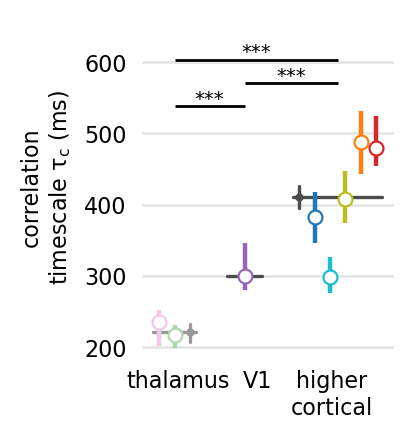

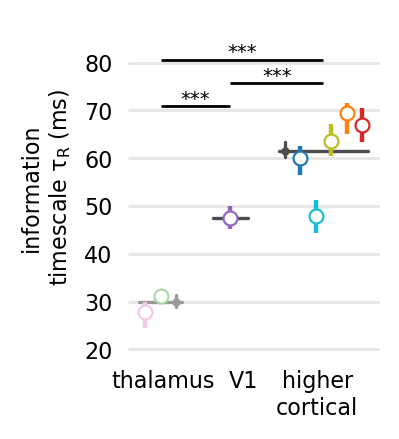

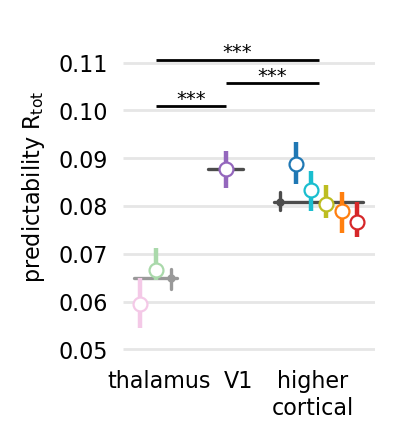

In [13]:
# Plot groups for main paper (natural_movie_one_more_repeats from functional connectivity data set)
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == 'merged_3.0_and_8.0')")

with plt.rc_context(rc_kwargs):
    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_double", ax=ax);
    # set ylims
    lims = [0.19, 0.66]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_grouped_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_R", ax=ax);
    # set ylims
    lims = [0.019, 0.089]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_grouped_tau_R.pdf", bbox_inches="tight", dpi=300)

    # # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "R_tot", ax=ax);
    # set ylims
    lims = [0.049, 0.119]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/fig2_grouped_R_tot.pdf", bbox_inches="tight", dpi=300)

2024-05-24 08:46:15,520 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:15,523 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 4823 rows
2024-05-24 08:46:16,981 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:16,983 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 4823 rows
2024-05-24 08:46:18,450 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:18,453 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 4823 rows


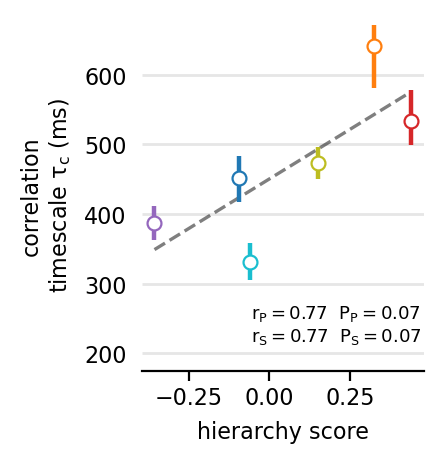

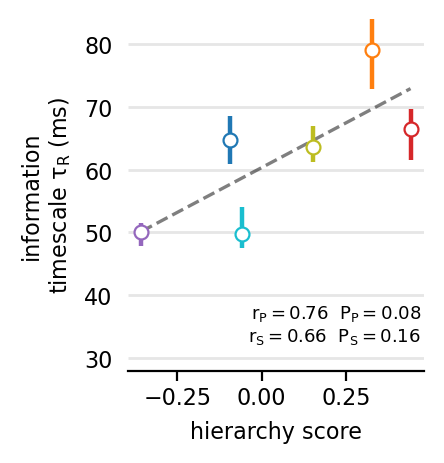

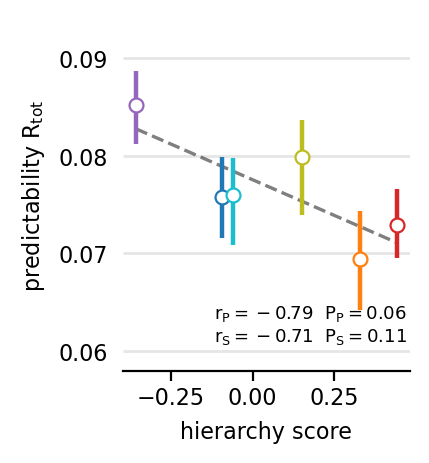

In [7]:
# For supplementaries, plot natural_movie_one_three from Brain_Observatory_1.1 data set
df = meta_df.query("(stimulus == 'natural_movie_three') & (block == 'merged_3.0_and_6.0')")

with plt.rc_context(rc_kwargs):
    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "tau_double", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.175, 0.68]
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_hierarchy_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "tau_R", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.028, 0.084]
    ax.set_ylim(lims)
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_hierarchy_tau_R.pdf", bbox_inches="tight", dpi=300)

    # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "R_tot", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.058, 0.094]
    ax.set_ylim(lims)
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_hierarchy_R_tot.pdf", bbox_inches="tight", dpi=300)


2024-05-24 08:46:20,157 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6181 rows
2024-05-24 08:46:23,156 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6181 rows
2024-05-24 08:46:26,244 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_three'] ['merged_3.0_and_6.0'] with 6181 rows


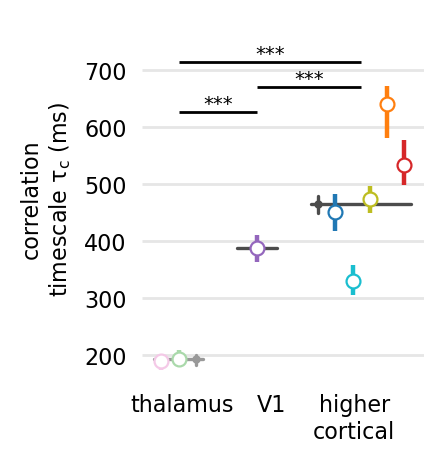

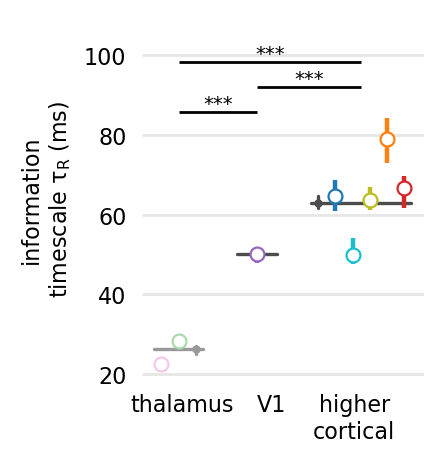

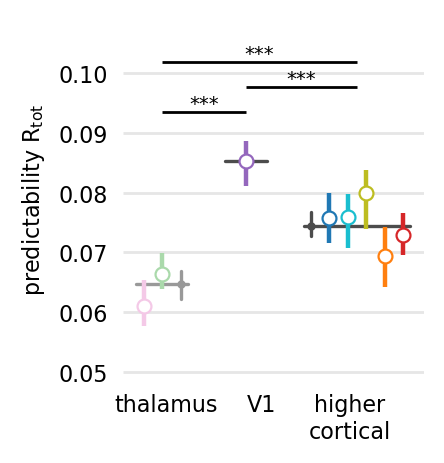

In [8]:
# For supplementaries plot groups for natural_movie_three from Brain_observertoy_1.1 data set)
df = meta_df.query("(stimulus == 'natural_movie_three') & (block == 'merged_3.0_and_6.0')")

with plt.rc_context(rc_kwargs):
    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_double", ax=ax);
    # set ylims
    lims = [0.16, 0.79]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_grouped_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_R", ax=ax);
    # set ylims
    lims = [0.019, 0.109]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_grouped_tau_R.pdf", bbox_inches="tight", dpi=300)

    # # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "R_tot", ax=ax);
    # set ylims
    lims = [0.049, 0.109]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/bo_grouped_R_tot.pdf", bbox_inches="tight", dpi=300)

2024-05-24 08:46:29,417 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:29,420 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['spontaneous'] ['null'] with 4674 rows
2024-05-24 08:46:30,905 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:30,908 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['spontaneous'] ['null'] with 4674 rows
2024-05-24 08:46:32,385 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2024-05-24 08:46:32,388 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['spontaneous'] ['null'] with 4674 rows


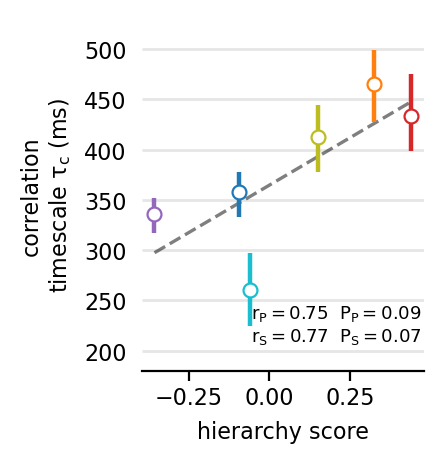

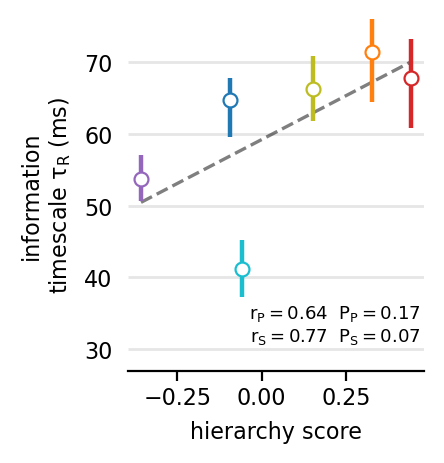

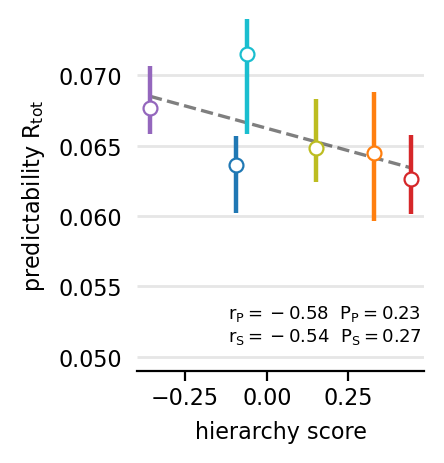

In [9]:
# For supplementaries, plot natural_movie_one_three from Brain_Observatory_1.1 data set
df = meta_df.query("(stimulus == 'spontaneous') & (block == 'null')")

with plt.rc_context(rc_kwargs):
    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "tau_double", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.18, 0.53]
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_hierarchy_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "tau_R", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.027, 0.076]
    ax.set_ylim(lims)
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_hierarchy_tau_R.pdf", bbox_inches="tight", dpi=300)

    # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ax, correlation_stats = ph.panel_hierarchy_score(df, "R_tot", ax=ax, plot_option="custom");
    # set ylims
    lims = [0.049, 0.074]
    ax.set_ylim(lims)
    r_p, p_p = correlation_stats["pearson"]
    r_s, p_s = correlation_stats["spearman"]
    text = ""
    text += r"$r_{\rm P} = " + f"{r_p:.2f}" + r"$" + "  "
    text += r"$P_{\rm P} = " + f"{p_p:.2f}" + r"$" + "\n"
    text += r"$r_{\rm S} = " + f"{r_s:.2f}" + r"$" + "  "
    text += r"$P_{\rm S} = " + f"{p_s:.2f}" + r"$" + "\n"
    text_kwargs = dict(
        s=text,
        fontsize=6.5,
        color="black",
        transform=ax.transAxes,
    )
    ax.text(0.99, 0.01, ha="right", va="bottom", **text_kwargs)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_hierarchy_R_tot.pdf", bbox_inches="tight", dpi=300)

2024-05-24 08:56:23,753 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['spontaneous'] ['null'] with 5495 rows
2024-05-24 08:56:26,634 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['spontaneous'] ['null'] with 5495 rows
2024-05-24 08:56:29,432 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['spontaneous'] ['null'] with 5495 rows


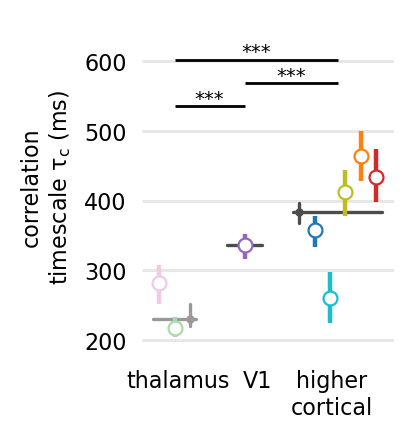

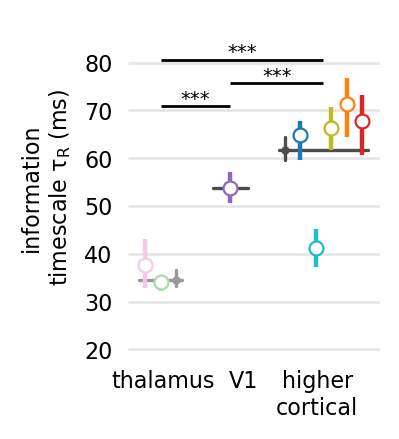

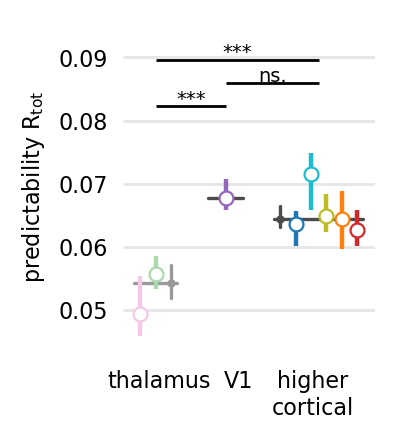

In [14]:
# For supplementaries plot groups for spontaneous activity from Functional Connectivity data set)
df = meta_df.query("(stimulus == 'spontaneous') & (block == 'null')")

with plt.rc_context(rc_kwargs):
    # plot correlation timescale tau_double
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_double", ax=ax);
    # set ylims
    lims = [0.18, 0.66]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_grouped_tau_double.pdf", bbox_inches="tight", dpi=300)

    # plot information timescale tau_R
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "tau_R", ax=ax);
    # set ylims
    lims = [0.019, 0.089]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_grouped_tau_R.pdf", bbox_inches="tight", dpi=300)

    # # plot predictability R_tot
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.98, left=0.1, bottom=0.1)
    ph.panel_areas_grouped(df, "R_tot", ax=ax);
    # set ylims
    lims = [0.043, 0.096]
    ax.set_ylim(lims)
    # save fig to disk
    set_size(ax, **size_kwargs)
    fig.savefig(f"../img/sp_grouped_R_tot.pdf", bbox_inches="tight", dpi=300)